# American Sign Language Recognition
Have you thought what it is like to not hear a thing? Not hearing birds chirping in the morning or listening to your favorite songs. Having trouble communicating with people who have normal hearing? Sounds like unbearable experience. There have always been a barrier between deaf people and people who have hearing but fortunately sign languages have been invented to help those people live a more normal lives. By creating a model that can translate pictures with handsigns into letters we are getting one step closer to normalising those peoples lifes. The American Sign Language is the 8th most used sign language in the world with around 460,000 estimate users and it is spoken in the United States. The dataset we are working with has 34,627 cases of which 27,455 are training data and 7172 are test data. The dataset format is very similar with the classic MNIST. It starts with label, pixel1, pixel2...pixel784. Each label is a number between 0 and 25 representing a letter from the English alphabet excluding number 9=J and 25=Z because they require movement and cannot be recognized by only using an image. All of the pixels with value between 0(darkest black) and 255(brightest white) combined on one row represent a 28x28 pixel grayscale image and thats why we have 784 pixel columns.

# Importing packages

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer


# Loading the ASL Dataset

In [40]:
train_data = pd.read_csv('sign_mnist_train/sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test/sign_mnist_test.csv')

# Getting basic information about the dataset

In [41]:
train_data.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       203       202  
1       175       103       135       149  
2       198       195       194       195  
3       225       222       229       163  
4       157       163       164       179  

[5 rows x 785 columns]

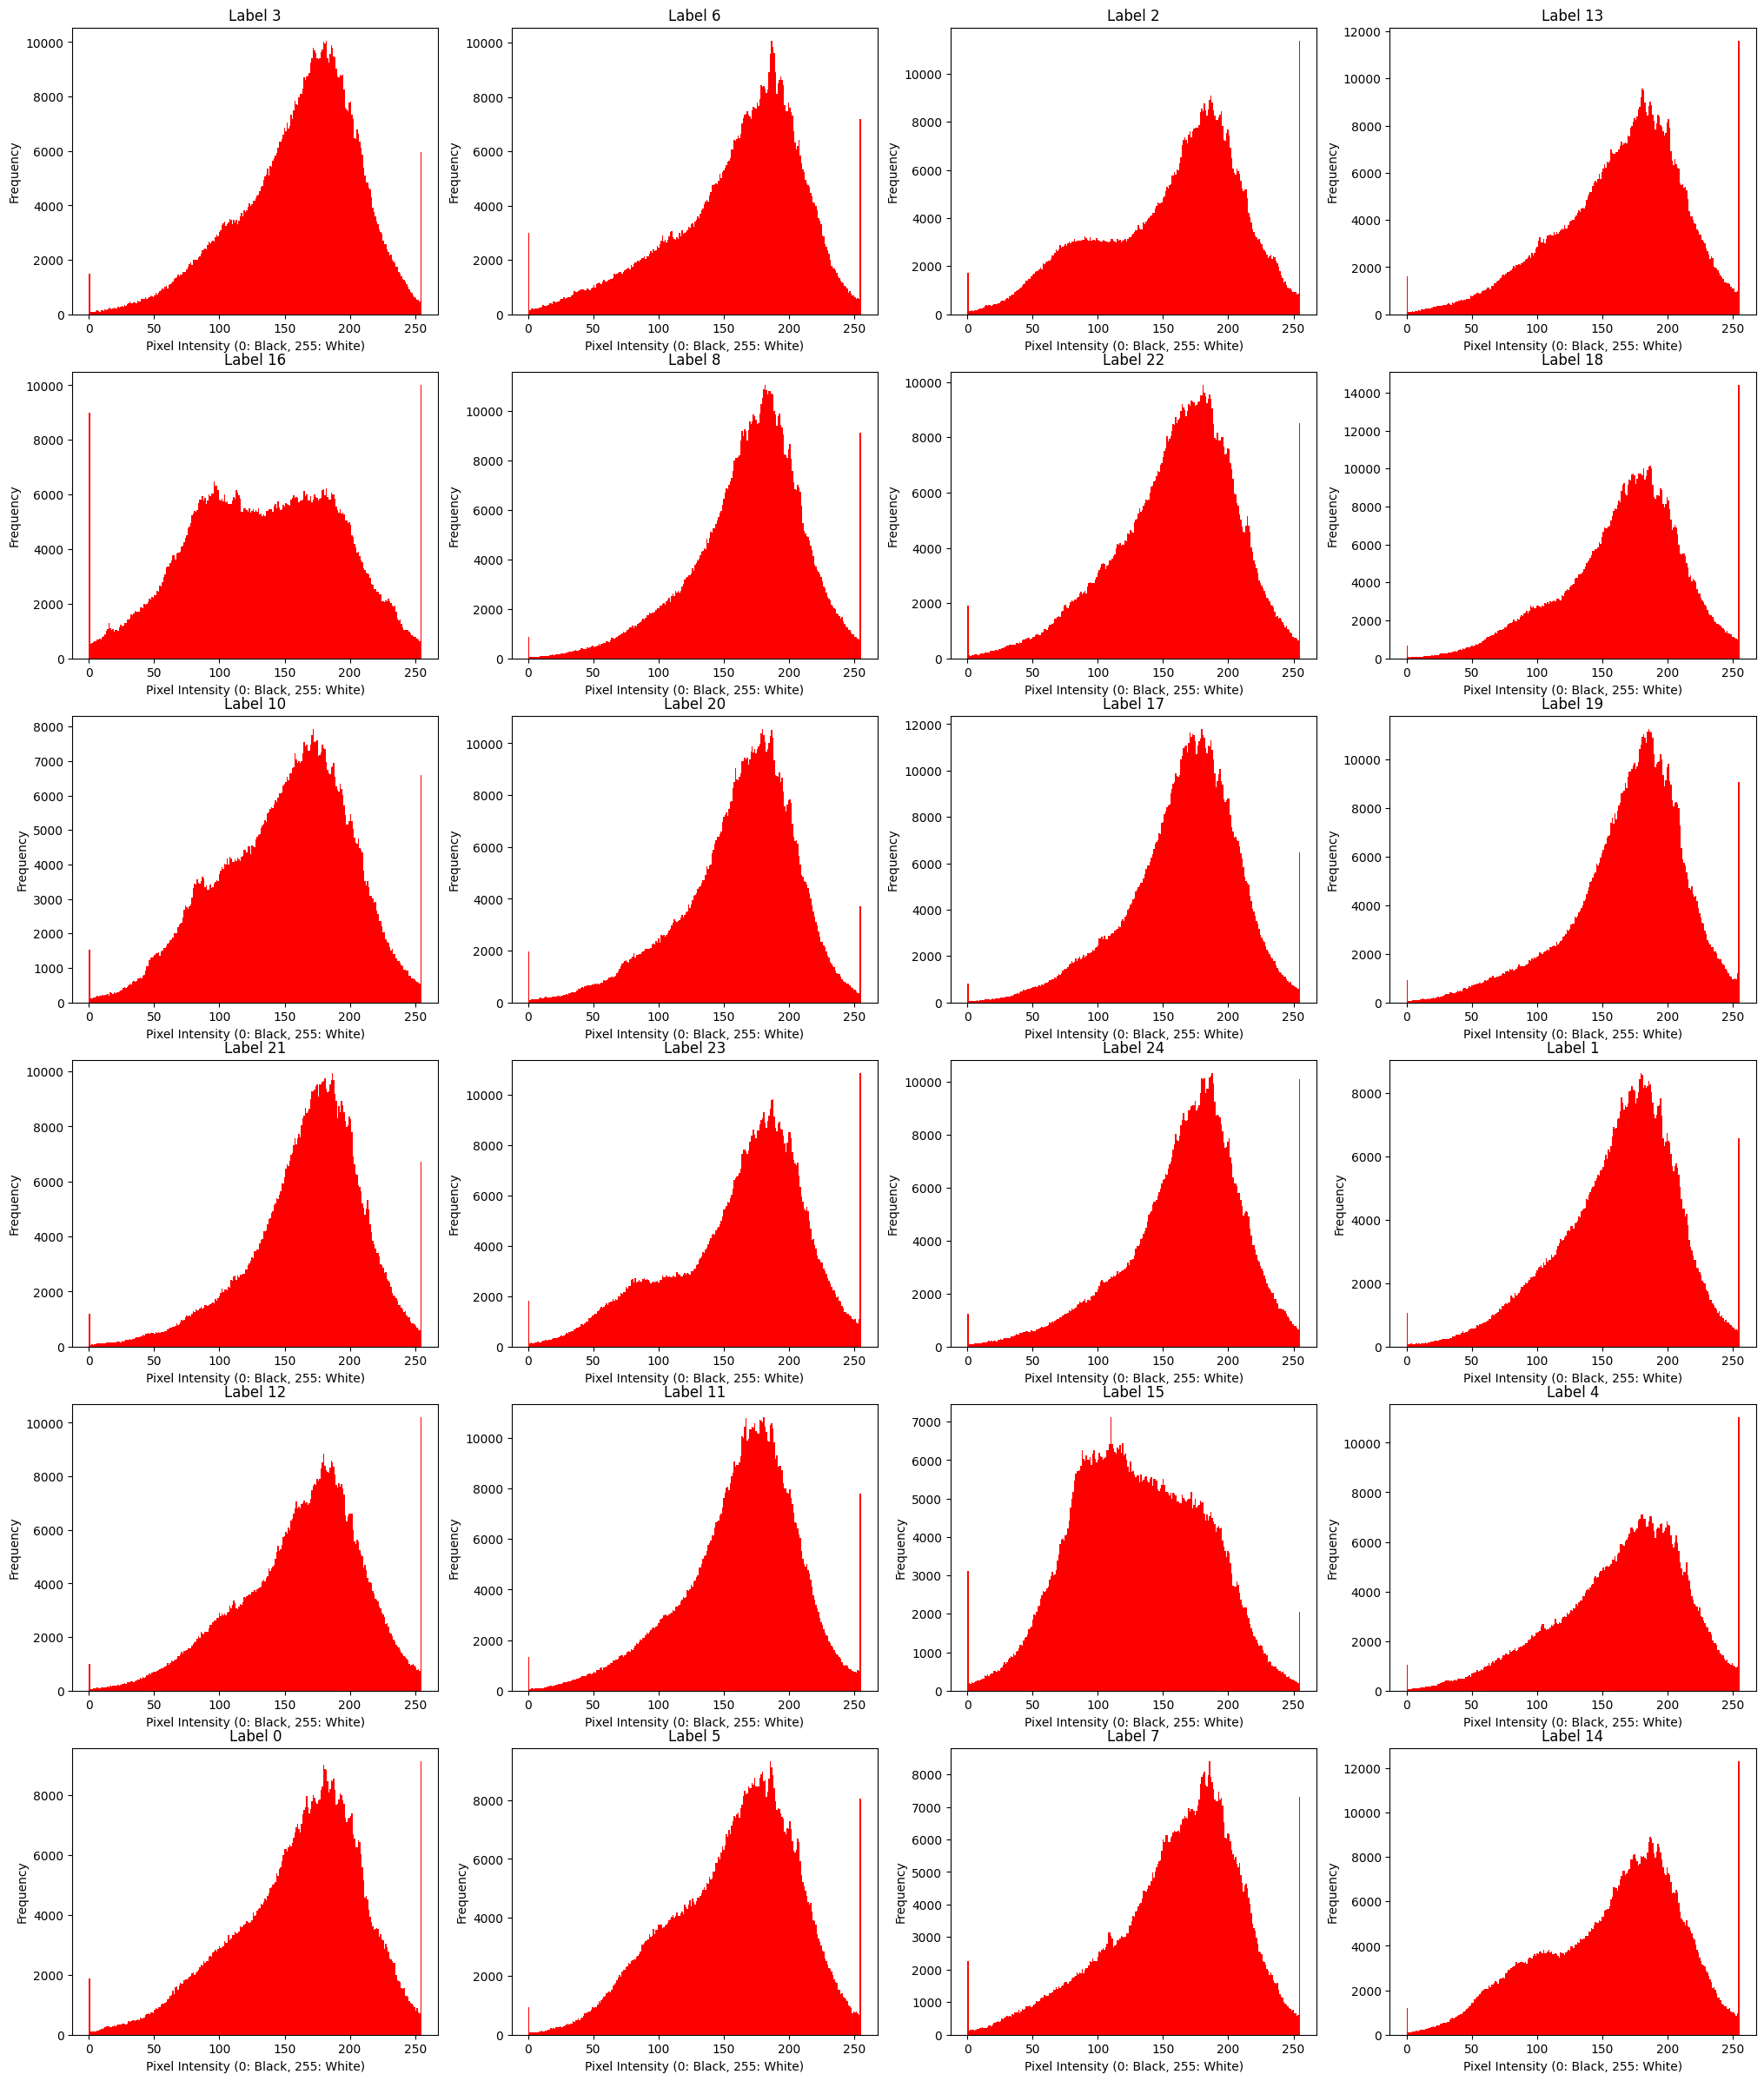

In [42]:
#we investigate the average frequency of the pixels in our dataset to check for abnormal values

fig, axes = plt.subplots(6, 4, figsize=(25, 30))
axes = axes.flatten()
labels_train = train_data['label']
labels_test = test_data['label']
unique_labels = labels_train.unique()
for i, label in enumerate(unique_labels):
    filtered_df = train_data[train_data['label'] == label]

    pixel_columns = train_data.columns[1:]
    pixel_values = filtered_df[pixel_columns].values.flatten()

    ax = axes[i]
    ax.hist(pixel_values, bins=256, range=(0, 255), color='red')
    ax.set_title(f'Label {label}')
    ax.set_xlabel('Pixel Intensity (0: Black, 255: White)')
    ax.set_ylabel('Frequency')

plt.show()

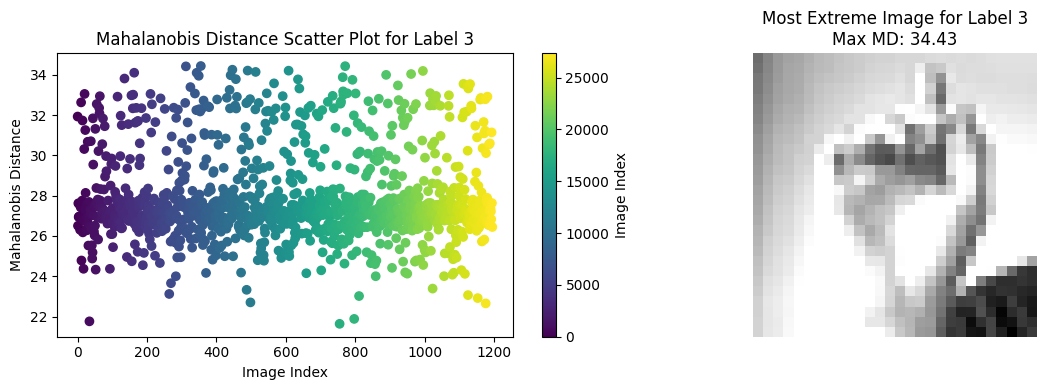

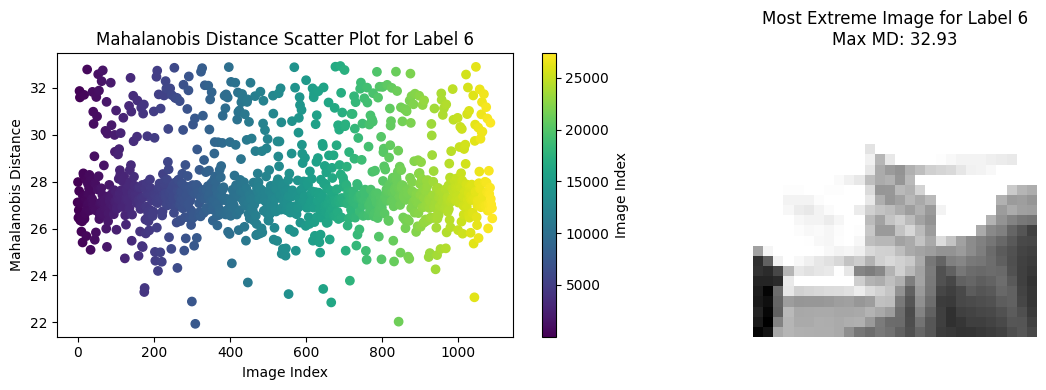

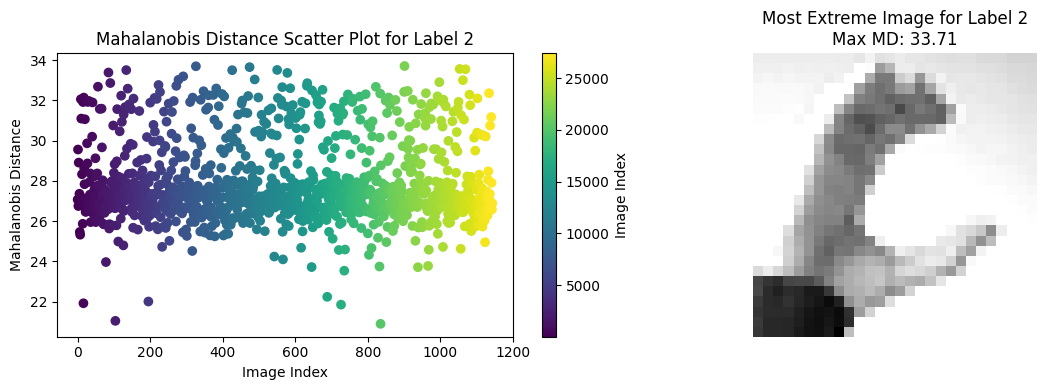

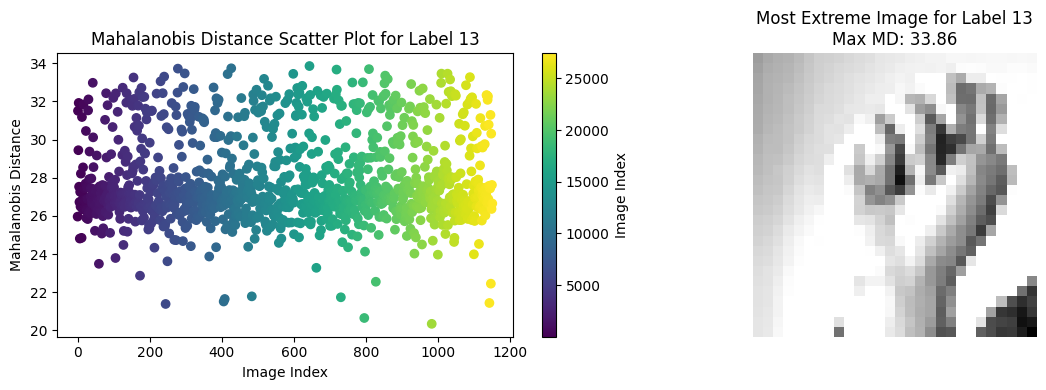

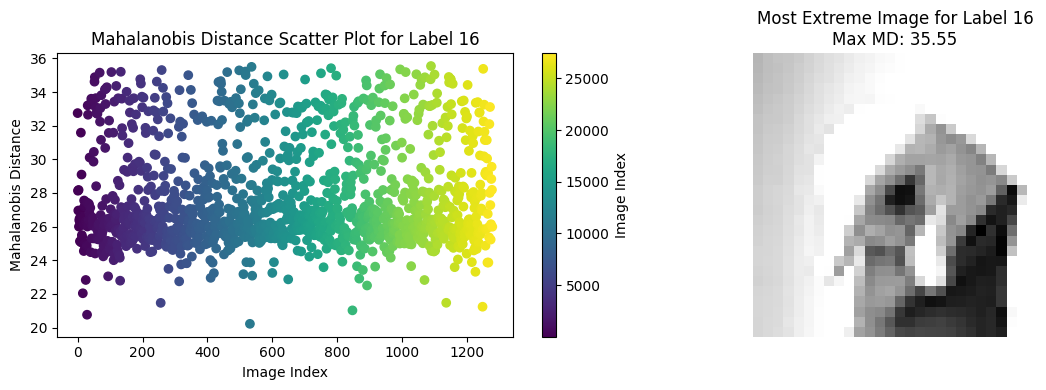

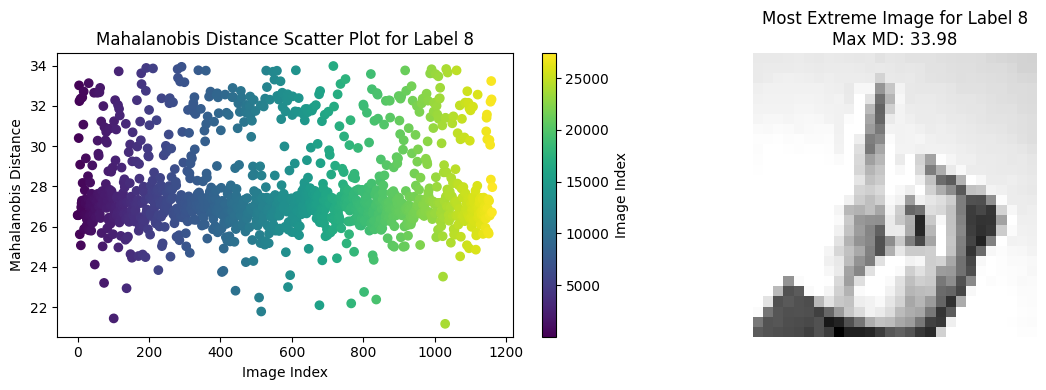

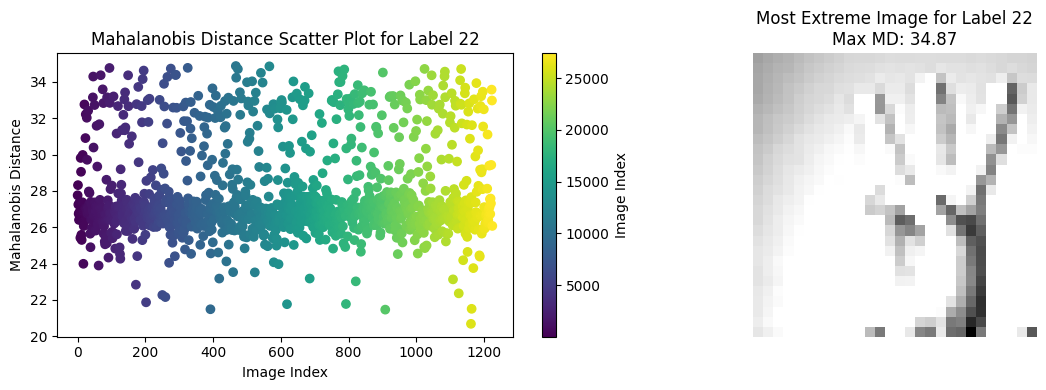

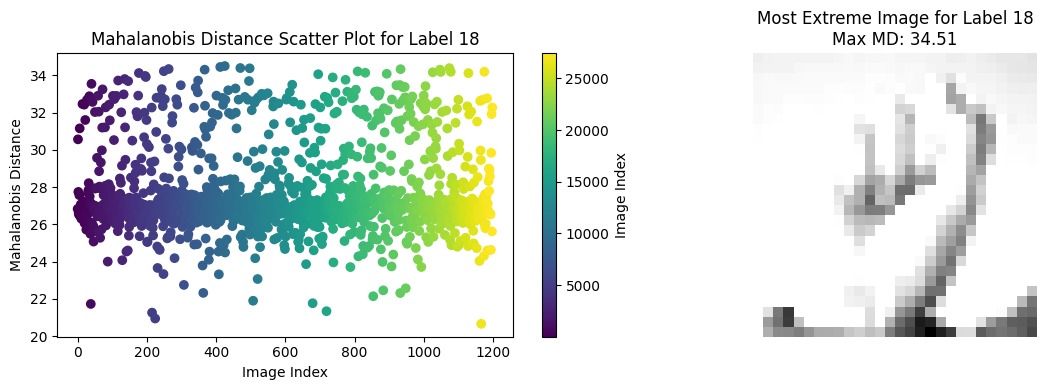

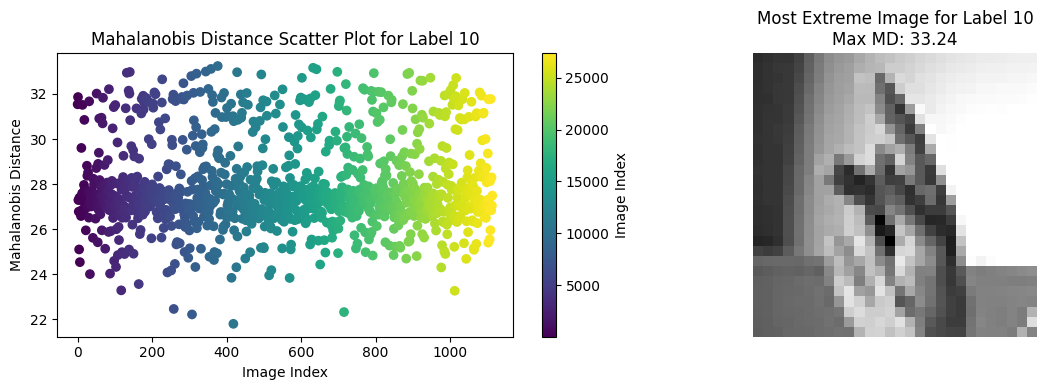

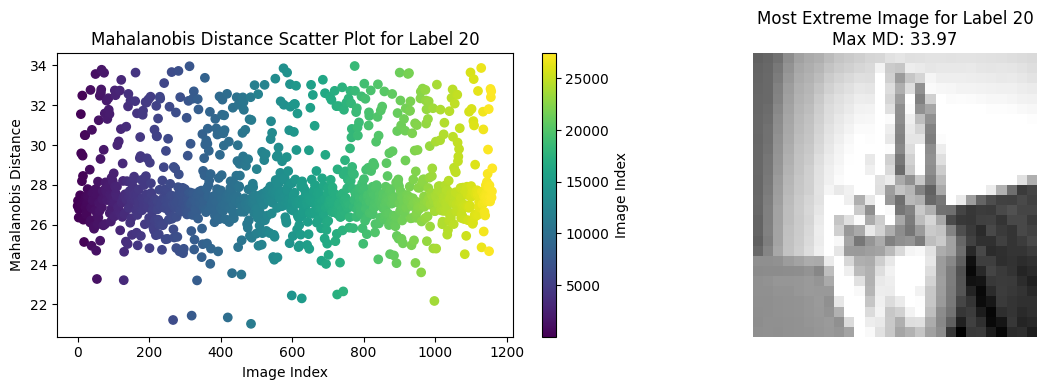

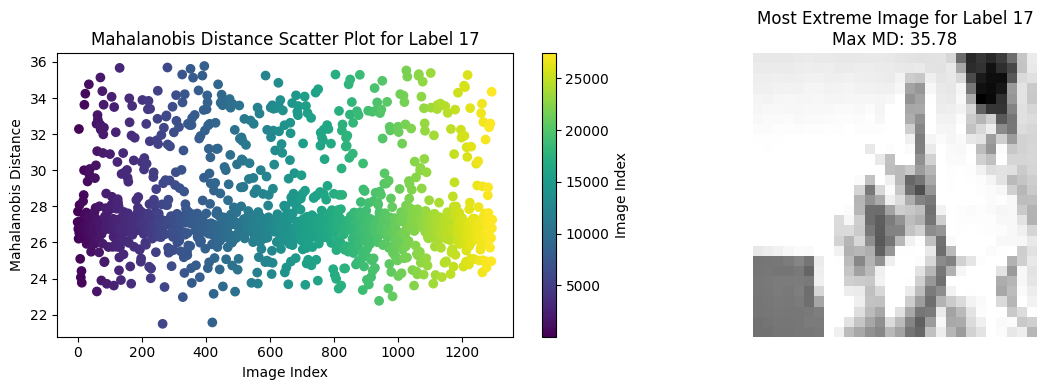

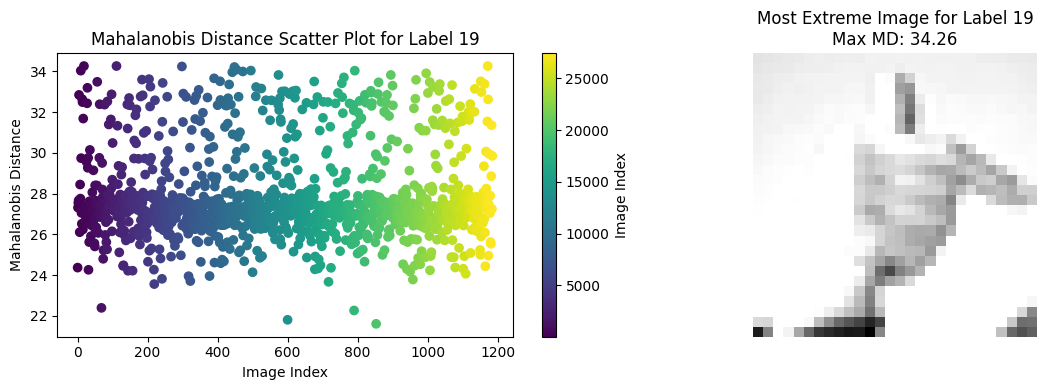

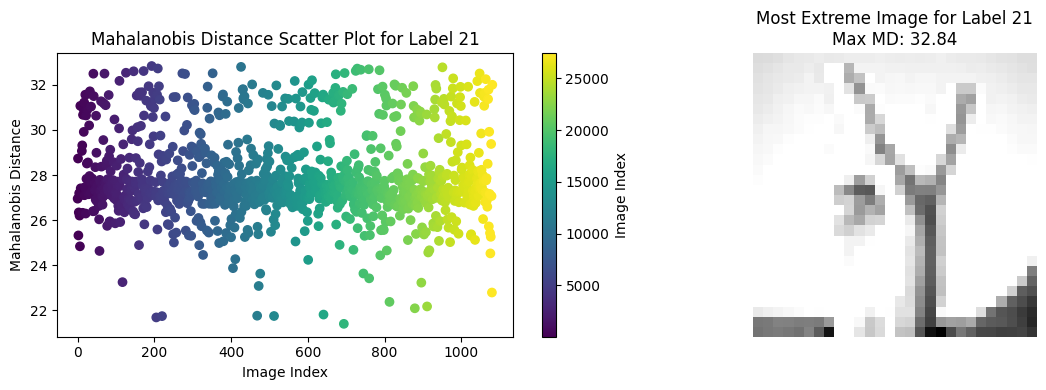

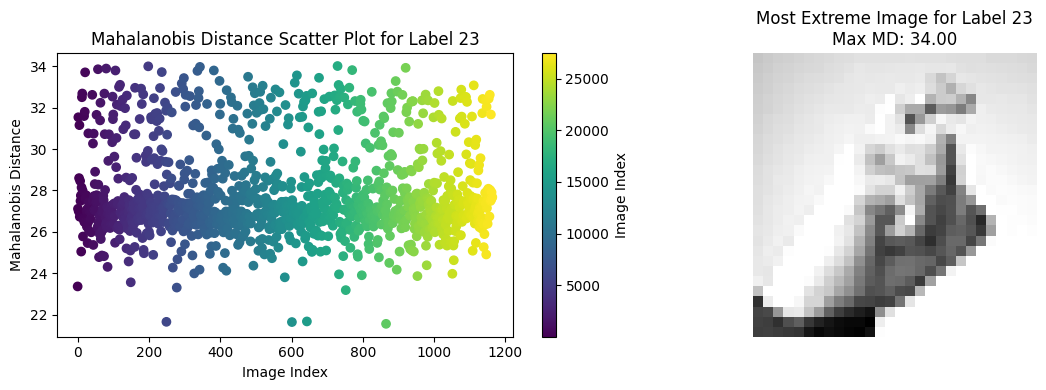

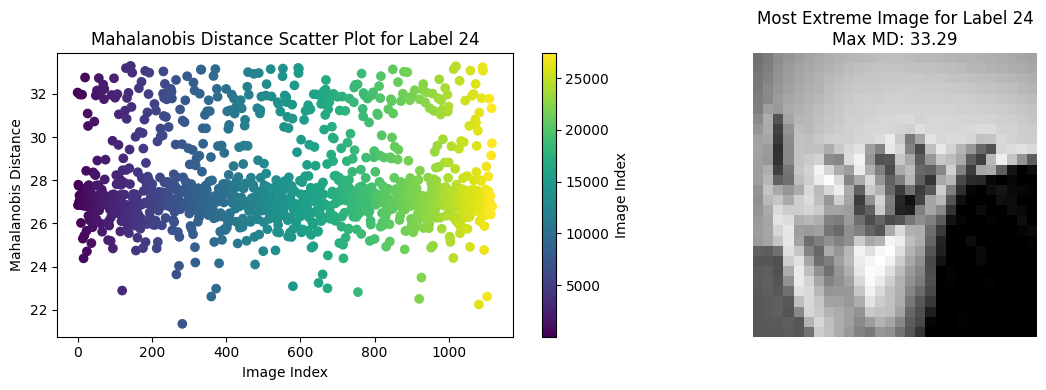

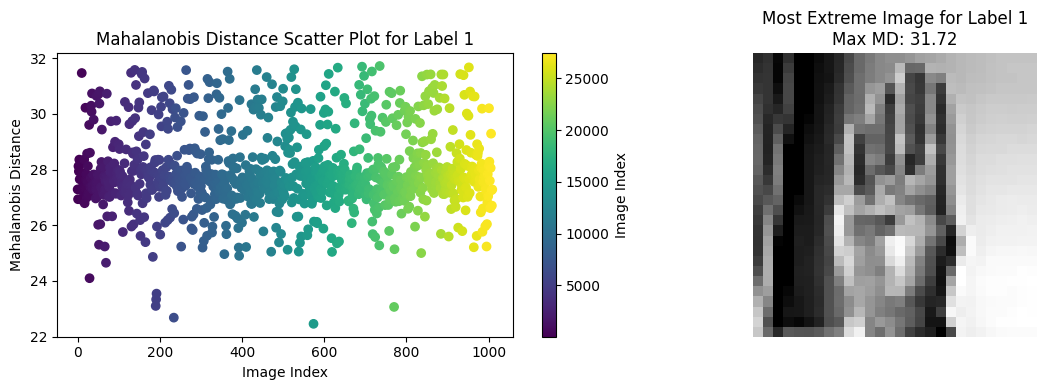

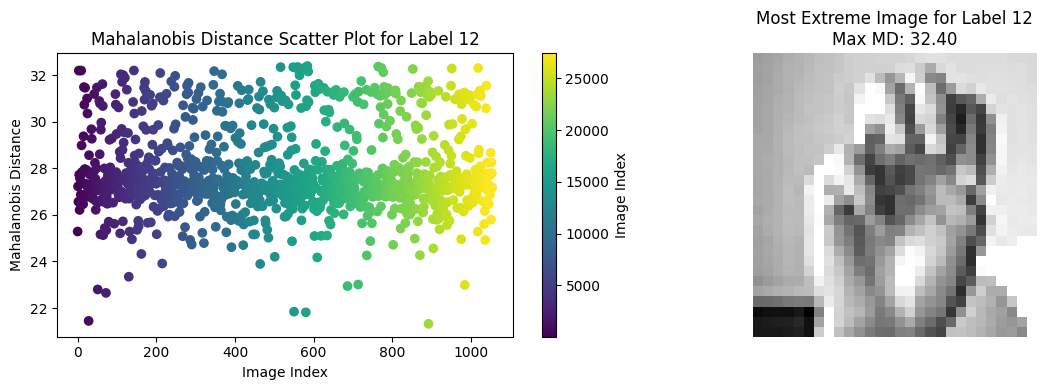

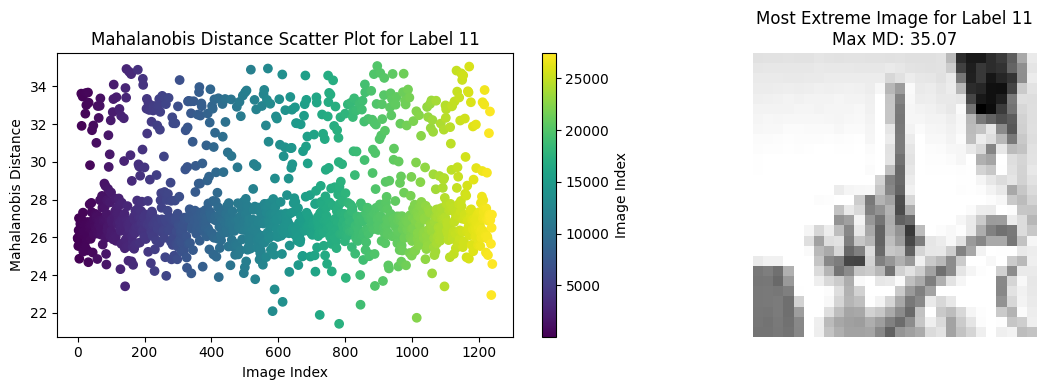

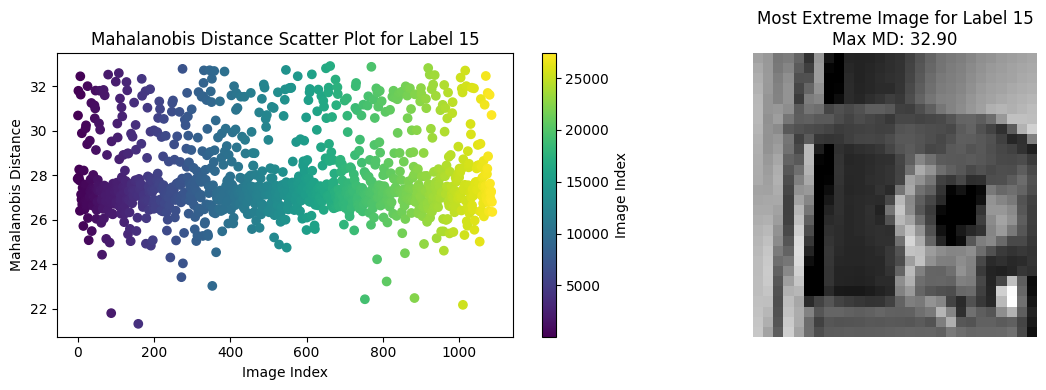

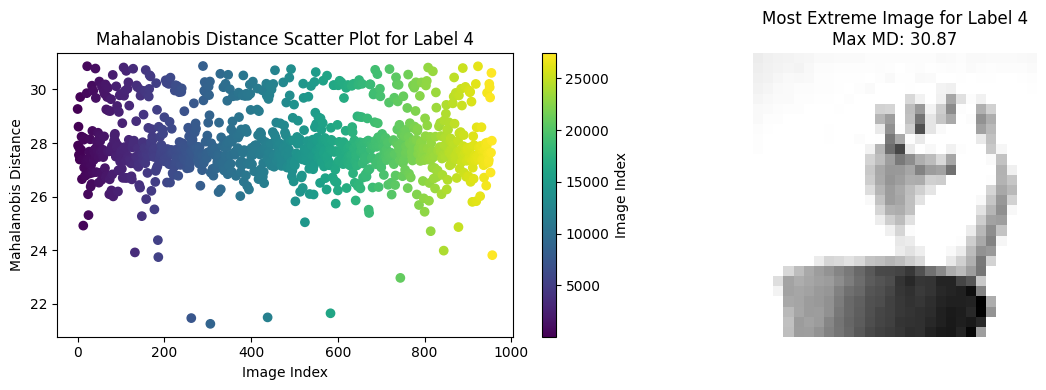

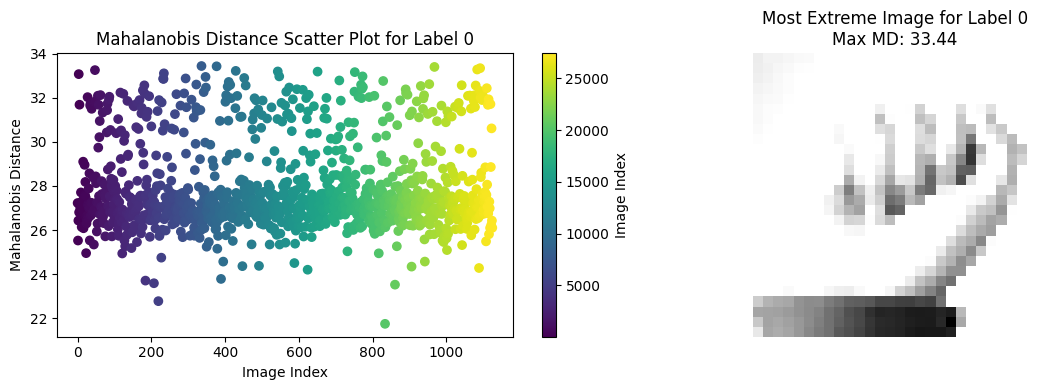

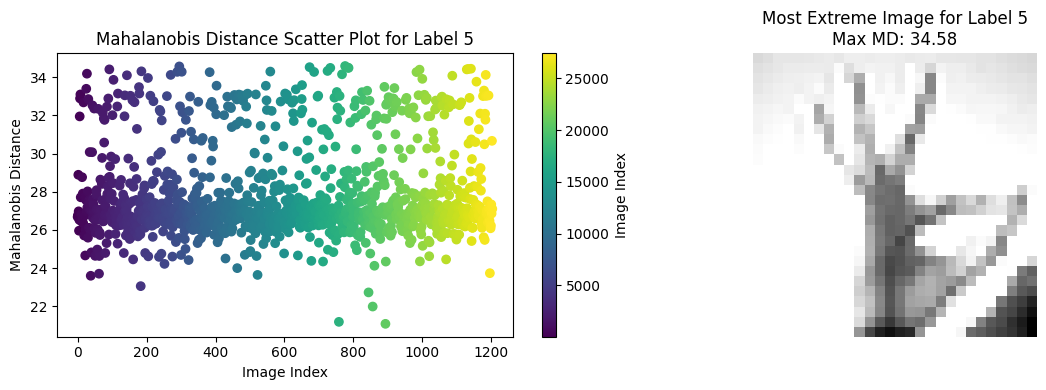

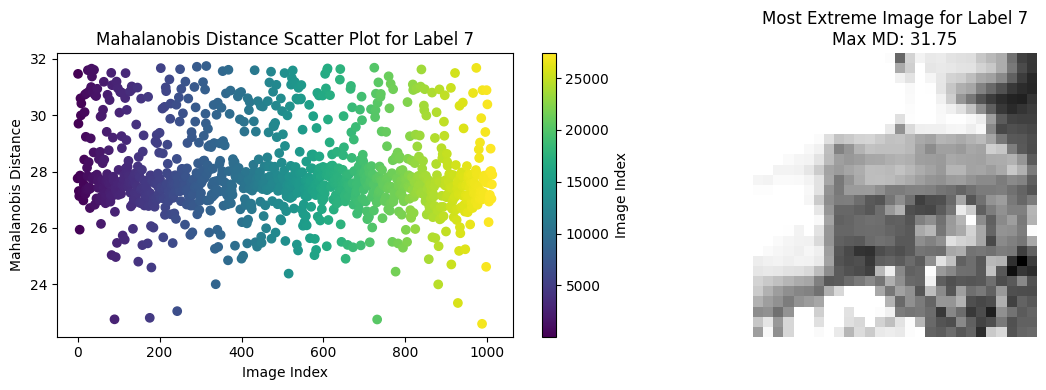

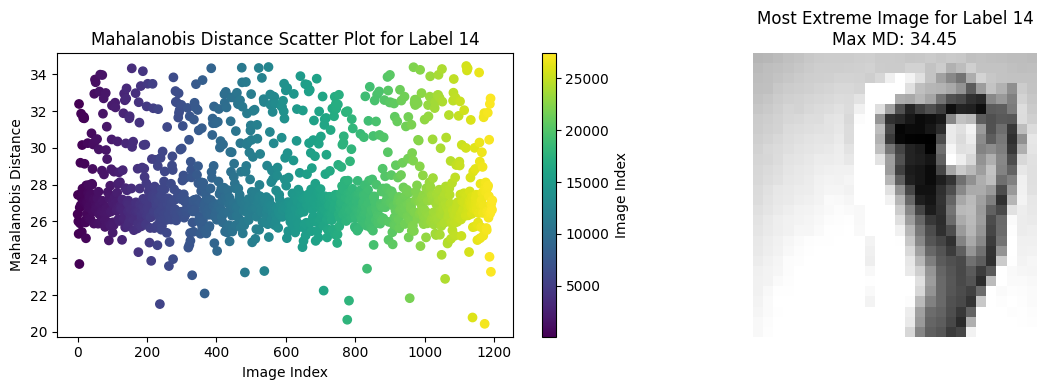

In [43]:
#this graph was made for DAIA and will probably be removed in the final submition. thats why there is not explaination for it.

for label in unique_labels:
    label_df = train_data[train_data['label'] == label]
    histograms = label_df.drop('label', axis=1).values

    # Step 2: Compute covariance matrix
    cov_matrix = np.cov(histograms, rowvar=False)

    # Step 3: Compute Mahalanobis distances
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_vector = np.mean(histograms, axis=0)
    diff = histograms - mean_vector
    mahalanobis_distances = np.sqrt(np.sum(np.dot(diff, inv_cov_matrix) * diff, axis=1))

    plt.figure(figsize=(12, 4))


    # Step 4: Plot Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(mahalanobis_distances)), mahalanobis_distances, c=label_df.index, cmap='viridis')
    plt.xlabel('Image Index')
    plt.ylabel('Mahalanobis Distance')
    plt.title(f'Mahalanobis Distance Scatter Plot for Label {label}')
    plt.colorbar(label='Image Index')
    
    max_index = np.argmax(mahalanobis_distances)

    # Step 6: Plot the most extreme value
    plt.subplot(1, 2, 2)
    plt.imshow(histograms[max_index].reshape(28, 28), cmap='gray')
    plt.title(f'Most Extreme Image for Label {label}\nMax MD: {mahalanobis_distances[max_index]:.2f}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [44]:
del train_data['label']
del test_data['label']

# Exploratory Data Analysis

Text(0.5, 1.0, 'Frequency of each letter')

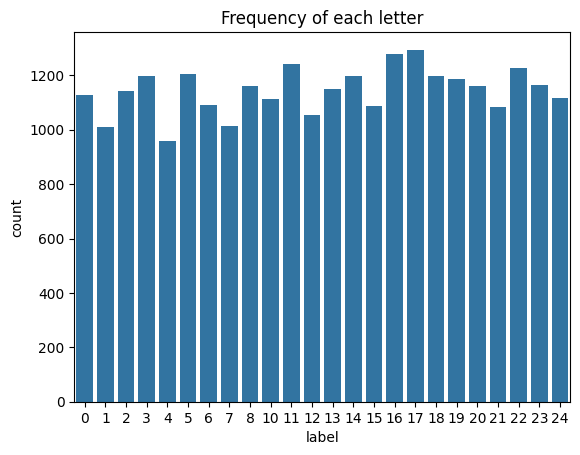

In [45]:
sns.countplot(x = labels_train)
plt.title("Frequency of each letter")

**There are more than 800 cases of each letter so the dataset is almost even. Also there are enough samples in it and we can start processing the data to use it for training.**

**First we devide the labels from the pixels and then we optimise the data containing the pixels by deviding it to 255 to get a value between 0 and 1 instead of 0 and 255 so the machine learning model can work faster.**

In [46]:
train_data = train_data / 255
test_data = test_data / 255
train_data.head() # label column is deleted

pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
0  0.419608  0.462745  0.498039  0.525490  0.545098  0.560784  0.572549   
1  0.607843  0.615686  0.611765  0.611765  0.611765  0.615686  0.611765   
2  0.733333  0.737255  0.737255  0.733333  0.733333  0.729412  0.733333   
3  0.827451  0.827451  0.831373  0.831373  0.827451  0.823529  0.827451   
4  0.643137  0.654902  0.666667  0.674510  0.690196  0.701961  0.705882   

     pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  pixel778  \
0  0.588235  0.600000  0.611765  ...  0.811765  0.811765  0.811765  0.811765   
1  0.619608  0.619608  0.615686  ...  0.270588  0.584314  0.501961  0.341176   
2  0.737255  0.733333  0.729412  ...  0.792157  0.788235  0.784314  0.780392   
3  0.823529  0.823529  0.827451  ...  0.921569  0.917647  0.913725  0.905882   
4  0.721569  0.725490  0.729412  ...  0.360784  0.411765  0.411765  0.423529   

   pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
0  0.807843  0.807843  0.807843  0.800000  0.796078  0.792157  
1  0.368627  0.639216  0.686275  0.403922  0.529412  0.584314  
2  0.776471  0.780392  0.776471  0.764706  0.760784  0.764706  
3  0.901961  0.886275  0.882353  0.870588  0.898039  0.639216  
4  0.521569  0.639216  0.615686  0.639216  0.643137  0.701961  

[5 rows x 784 columns]

## Visualization of the grayscale images

**Converting the dataframe into NumPy arrays so we can use matplotlib's functions and also optimise the performance of the machine learning algorithms. Reshaping the flat array into a 2D array so we can display the sign examples**

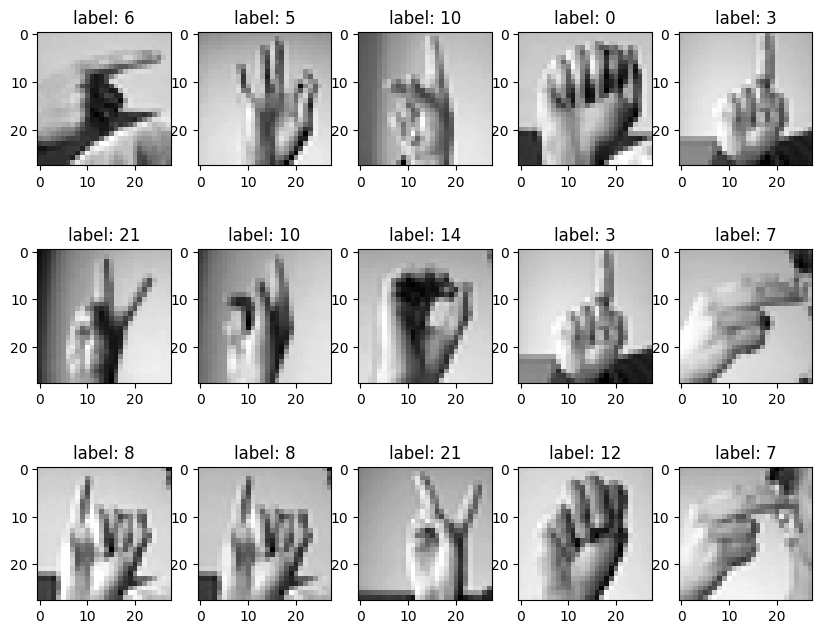

In [47]:
train_data = train_data.values
test_data = test_data.values
fig, axe = plt.subplots(3,5)
fig.set_size_inches(10,8)

index = 0
for i in range(3):
    for j in range(5):
        image = test_data[index].reshape(28, 28)
        label = labels_test[index]

        axe[i, j].imshow(image, cmap = 'gray')
        axe[i, j].set_title(f"label: {label}")
        index +=1
plt.show()


# Converting the integer labels to binary form
The label dataframe consist of single values from 1 to 24 for each individual picture. The CNN output layer will be of 24 nodes since it has 24 different labels as a multi label classifier. Hence each integer is encoded in a binary array of size 24 with the corresponding label being 1 and all other labels are 0. Such as if y=4 the the array is [0 0 0 1 0 0.....0].

In [48]:
lb = LabelBinarizer()
labels_train = lb.fit_transform(labels_train)
labels_test = lb.fit_transform(labels_test)

# Data Augmentation

Adding more cases of the same images slightly changed. We use changes such as slight rotation, zoom in, shifting images horizontally or vertically. By doing this we enrich our dataset and we are able to feed the machine learning algorithm with more data in order to have better accuracy. Before feeding our original data into the ImageDataGenerator we have to transform the dataframe into 4D array so we can use the function.

In [49]:
train_data = train_data.reshape(-1, 28, 28, 1) ## -1 means all the rows, 28 is height, 28 is width and 1 is the channels of the image which is 1 because it is a grayscale
test_data = test_data.reshape(-1, 28, 28, 1)

# new_train_data = np.array([cv2.resize(img, (64, 64)) for img in train_data])
# new_test_data = np.array([cv2.resize(img, (64, 64)) for img in test_data])

generated_data = ImageDataGenerator(
    rotation_range = 10, # degrees
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    zoom_range = 0.1,
)
generated_data.fit(train_data)

print(train_data.shape)
print(test_data.shape)



(27455, 28, 28, 1)
(7172, 28, 28, 1)


# Creating Convulutional Neural Network Model
**A convulutional layer** is a layer that goes through the image and search for distinguishable differences. Our first convolutional layer has those parameters:

**75** are the number of filters we are looking for,

**(3, 3)** is the height and width in pixels of our filter so we will look for those differences in this small part of the image,

**strides=1** are the steps we move in pixels after applying each filter which is 1 because we want to catch every possible difference,

**padding='same'** means that there is no padding and we are using the original image,

**activation='relu'** means that we are using REctified Linear Unit function which ignores negative values and therefore not making our model "learn" when there are values lower than zero because they do not have any significance,

**input_shape=(28, 28, 1)** is just the dimensions of our images(28x28) and the amount of channels which is 1 because it is a grayscale.

**A Pooling layer** takes the significant differences found using the convolutional layer and makes a smaller image which is more saturated on distinguishable differences

**pool_size** are the dimensions of the filter. As mentioned earlier it needs to be smaller than the convolution so we are making it a pixel smaller.

**strides=2** steps we move through the recognized features.

**padding='same'** we are using the original image

Our convolutional layers' filter count are less after each iteration because we are working with bigger part of the image and therefore it is logical to look for less differences because they are combined in bigger groups. Our pooling layers stay the same because their job does not change based on the size.

**Flatten** Flattening takes the output of the previous layer, which is typically a multidimensional array representing feature maps (e.g., a 3D array for width, height, and channels), and converts it into a single, one-dimensional vector.This transformation allows the fully-connected layers to process the extracted features.

In [50]:
model = Sequential() # sequential means that it add layers one after another
model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
# 
model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(Flatten())


d:\Users\yaniy\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Dense layer** adds a fully connected layer. It has 512 neurons and uses ReLU activation function which we explained earlier. It analyzes the combined features from previous layers looking for patterns between different classes.

**Dropout layer** helps preventing overfitting. Randomly deactivates 25% of neurons in a layer. Weights of neurons are tuned for specific features, providing some specialization. Neighboring neurons come to rely on this specialization, which, if taken too far, can result in a fragile model too specialized for the training data. You can imagine that if neurons are randomly dropped out of the network during training, other neurons will have to step in and handle the representation required to make predictions for the missing neurons. 

**Second Dense layer**'s units are equal to the number of labels we have (24) and we have activation='softmax'. Softmax is useful for multiclass classification problems. 

**Optimizer** is an algorithm that guides the learning process. It adjusts the weights and biases of the network's neurons based on the errors it makes. Adam is popular and efficient optimizer.

**Loss** is a mathematical function that measures how well our model's predictions match the actual labels. Categorical crossentropy is a common loss function for multi-class problems.

**Metrics** are functions that track the performance of our model. Accuracy means that it shows the percentage of correct predictions.


In [51]:
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=24,activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()
print(model.input_shape)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,449 (1.00 MB)

 Trainable params: 263,449 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

(None, 28, 28, 1)


# Training the model

In [52]:
history = model.fit(generated_data.flow(train_data, labels_train, batch_size=128), epochs=20, validation_data=(test_data, labels_test),shuffle=1)

d:\Users\yaniy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.1792 - loss: 2.7406 - val_accuracy: 0.7832 - val_loss: 0.7338
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.7128 - loss: 0.8760 - val_accuracy: 0.8855 - val_loss: 0.3348
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8494 - loss: 0.4534 - val_accuracy: 0.9338 - val_loss: 0.1996
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9043 - loss: 0.2811 - val_accuracy: 0.9706 - val_loss: 0.1030
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9327 - loss: 0.2011 - val_accuracy: 0.9827 - val_loss: 0.0562
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.9497 - loss: 0.1511 - val_accuracy: 0.9852 - val_loss: 0.0523
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.9610 - loss: 0.1172 - val_accuracy: 0.9888 - val_loss: 0.0394
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9719 - loss: 0.0857 - 

# Accuracy of model

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9950 - loss: 0.0218
Accuracy of the model is -  99.55381751060486 %
225/225 - 1s - 5ms/step - accuracy: 0.9955 - loss: 0.0209


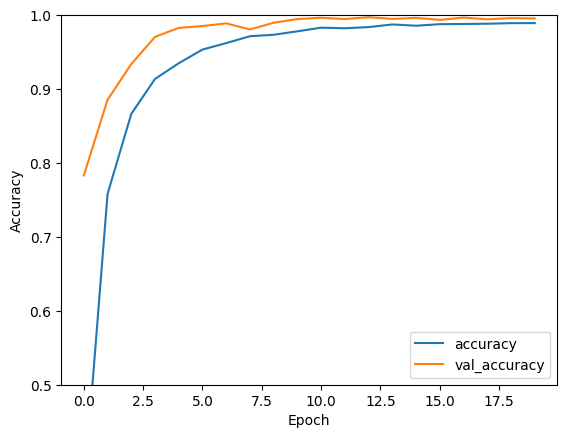

In [53]:
print("Accuracy of the model is - " , model.evaluate(test_data,labels_test)[1]*100 , "%")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_data,  labels_test, verbose=2)

# Saving the current state of the model

In [54]:
model.save('sign_language.keras')

# Evaluation

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


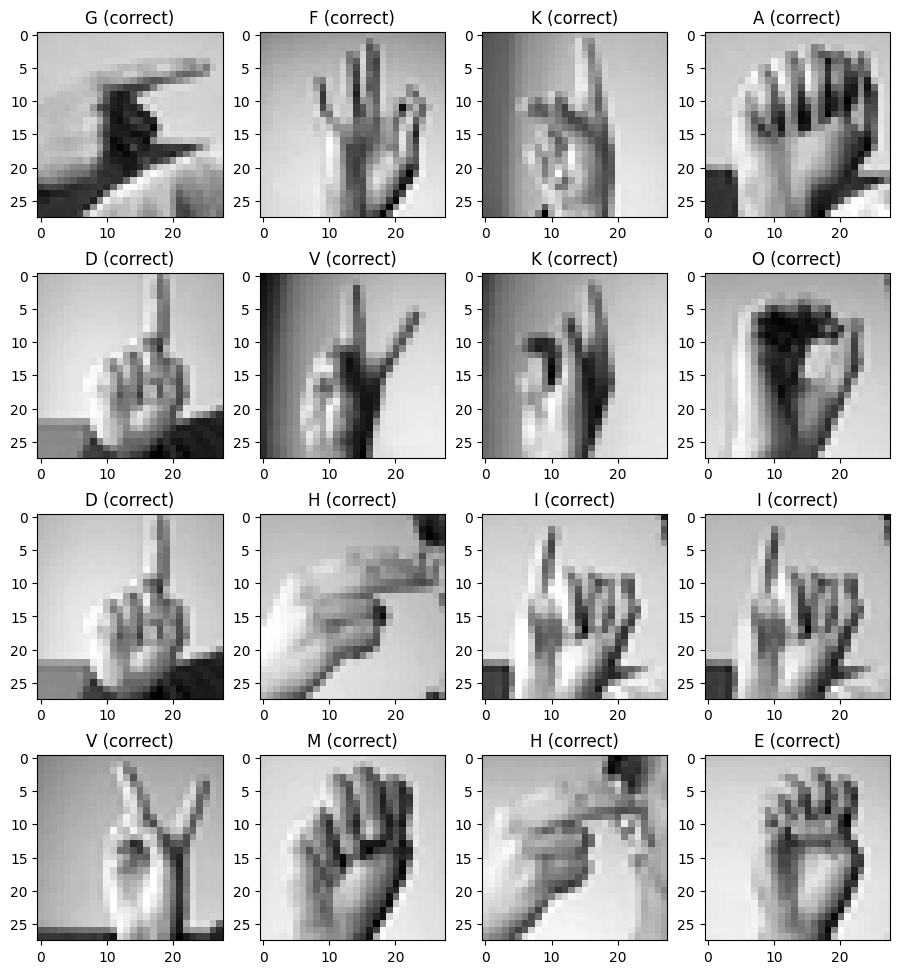

In [55]:
alphabet = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")


predictions = model.predict(test_data)
predictions = lb.inverse_transform(predictions)
predicted_letters = [alphabet[idx] for idx in predictions]

true_labels = lb.inverse_transform(labels_test)


_, subplots = plt.subplots(nrows=4, ncols=4)
_.set_size_inches(11,12)
subplots = subplots.flatten()

for i in range(16):
  title_text = f"{predicted_letters[i]} (correct)" if predictions[i] == true_labels[i] else f"{predictions[i]} (wrong)"
  subplots[i].imshow(test_data[i], cmap='gray')
  subplots[i].set_title(title_text)
plt.show()


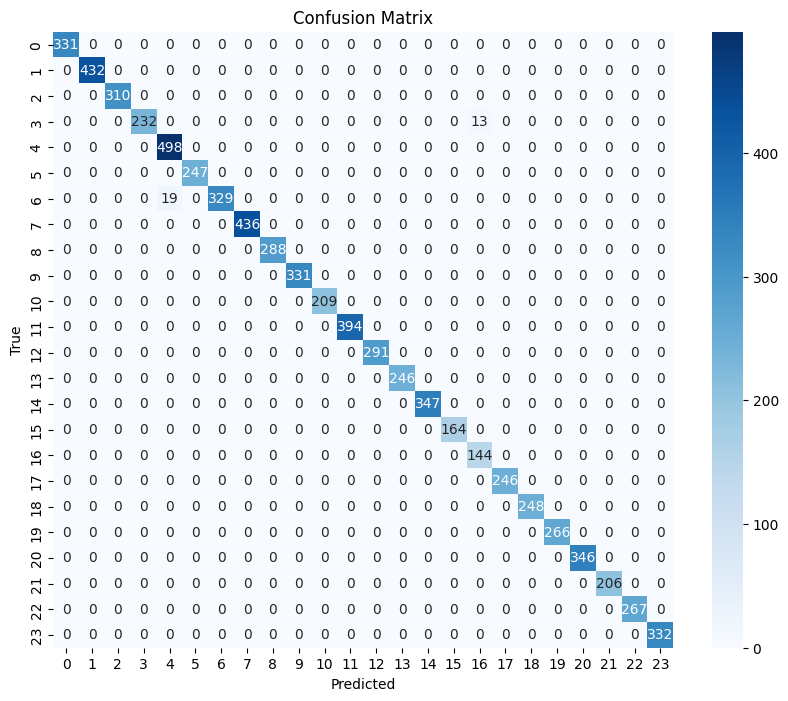

In [56]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [57]:
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      0.95      0.97       245
           4       0.96      1.00      0.98       498
           5       1.00      1.00      1.00       247
           6       1.00      0.95      0.97       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.92      1.00      0.96       144
          18       1.00    